In [2]:
import numpy as np
import duckdb
import pandas as pd
#import seaborn as sns
import statsmodels.formula.api as sfm
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from scipy.stats import chi2_contingency
from scipy.stats import norm
import matplotlib.pyplot as plt

## Research Question: 


### Where on the ice do teams typically execute their zone entries (e.g., near the blue line, along the boards)?

In [67]:
df = pd.read_csv('BDC_2024_Womens_Data.csv')
df.columns
df

,Date,Home Team,Away Team,Period,Clock,Home Team Skaters,Away Team Skaters,Home Team Goals,Away Team Goals,Team,...,Event,X Coordinate,Y Coordinate,Detail 1,Detail 2,Detail 3,Detail 4,Player 2,X Coordinate 2,Y Coordinate 2
0,2023-11-08,Women - United States,Women - Canada,1,20:00,5,5,0,0,Women - Canada,...,Faceoff Win,100,42,Backhand,NaN,NaN,NaN,Taylor Heise,NaN,NaN
1,2023-11-08,Women - United States,Women - Canada,1,19:57,5,5,0,0,Women - Canada,...,Puck Recovery,50,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2023-11-08,Women - United States,Women - Canada,1,19:54,5,5,0,0,Women - Canada,...,Play,3,59,Indirect,NaN,NaN,NaN,Renata Fast,4.0,35.0
3,2023-11-08,Women - United States,Women - Canada,1,19:52,5,5,0,0,Women - Canada,...,Play,6,21,Direct,NaN,NaN,NaN,Emma Maltais,48.0,2.0
4,2023-11-08,Women - United States,Women - Canada,1,19:50,5,5,0,0,Women - Canada,...,Incomplete Play,48,2,Direct,NaN,NaN,NaN,Marie-Philip Poulin,62.0,28.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7454,2023-12-16,Women - Canada,Women - United States,4,0:12,3,3,2,2,Women - Canada,...,Puck Recovery,164,82,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7455,2023-12-16,Women - Canada,Women - United States,4,0:09,3,3,2,2,Women - Canada,...,Shot,186,47,Snapshot,On Net,f,f,NaN,NaN,NaN
7456,2023-12-16,Women - Canada,Women - United States,4,0:06,3,3,2,2,Women - United States,...,Puck Recovery,22,36,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7457,2023-12-16,Women - Canada,Women - United States,4,0:03,3,3,2,2,Women - United States,...,Play,18,32,Direct,NaN,NaN,NaN,Hilary Knight,129.0,63.0


In [81]:
#First we need to filter the data, so we get all the data focused on the zone entries and separate the data based 
#on whether they were dumped or carried

zone_entries = df[df['Event'] == 'Zone Entry']
dumped_entries = zone_entries[zone_entries['Detail 1'] == 'Dumped']
carried_entries = zone_entries[zone_entries['Detail 1'] == 'Carried']

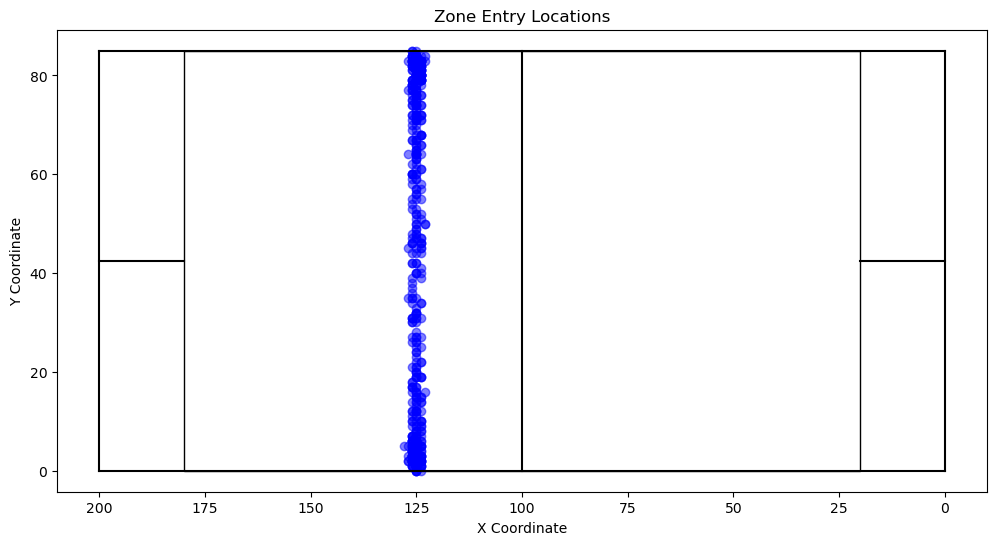

In [82]:
#Function to draw hockey rink
def draw_hockey_rink(ax):
    # Define rink boundaries
    ax.plot([0, 200], [0, 0], color='black')  # End boards
    ax.plot([0, 0], [0, 85], color='black')   # Left boards
    ax.plot([200, 200], [0, 85], color='black')  # Right boards
    ax.plot([0, 200], [85, 85], color='black')  # Goal line
    ax.plot([100, 100], [0, 85], color='black')  # Center line
    ax.plot([0, 20], [42.5, 42.5], color='black')  # Left blue line
    ax.plot([180, 200], [42.5, 42.5], color='black')  # Right blue line
    ax.add_patch(plt.Rectangle((20, 0), 160, 85, edgecolor='black', facecolor='none'))  # Rink area

# Set up the figure
fig, ax = plt.subplots(figsize=(12, 6))

# Draw hockey rink
draw_hockey_rink(ax)

# Plot the zone entries
ax.scatter(zone_entries['X Coordinate'], zone_entries['Y Coordinate'], color='blue', alpha=0.5)

# Title and labels
ax.set_title('Zone Entry Locations')
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')

# Invert x-axis
ax.invert_xaxis()

plt.show()


From this diagram we can see that most of the zone entries are concentrated at the line x = 125, which is going into the offence zone. To understand why its implications, we will conduct an analysis to determine whether there are specific periods or situations during games where zone entries near x = 125 are more prevalent. Understanding when and why the team employs this strategy can provide valuable insights into their overall game plan.

In [83]:
zone_entries_copy = zone_entries.copy()  # Create a copy of the DataFrame

# Convert 'Clock' column to datetime
zone_entries_copy['Clock'] = pd.to_datetime(zone_entries_copy['Clock'], format='%M:%S')

# Extract minute and second components
zone_entries_copy['Minute'] = zone_entries_copy['Clock'].dt.minute
zone_entries_copy['Second'] = zone_entries_copy['Clock'].dt.second

# Now assign the modified copy back to the original DataFrame
zone_entries = zone_entries_copy
zone_entries

,Date,Home Team,Away Team,Period,Clock,Home Team Skaters,Away Team Skaters,Home Team Goals,Away Team Goals,Team,...,Y Coordinate,Detail 1,Detail 2,Detail 3,Detail 4,Player 2,X Coordinate 2,Y Coordinate 2,Minute,Second
13,2023-11-08,Women - United States,Women - Canada,1,1900-01-01 00:19:36,5,5,0,0,Women - Canada,...,6,Carried,NaN,NaN,NaN,Haley Winn,NaN,NaN,19,36
20,2023-11-08,Women - United States,Women - Canada,1,1900-01-01 00:19:23,5,5,0,0,Women - United States,...,52,Dumped,NaN,NaN,NaN,Erin Ambrose,NaN,NaN,19,23
24,2023-11-08,Women - United States,Women - Canada,1,1900-01-01 00:19:18,5,5,0,0,Women - Canada,...,80,Carried,NaN,NaN,NaN,Rory Guilday,NaN,NaN,19,18
39,2023-11-08,Women - United States,Women - Canada,1,1900-01-01 00:18:56,5,5,0,0,Women - United States,...,84,Played,NaN,NaN,NaN,Ashton Bell,NaN,NaN,18,56
43,2023-11-08,Women - United States,Women - Canada,1,1900-01-01 00:18:48,5,5,0,0,Women - Canada,...,63,Carried,NaN,NaN,NaN,Savannah Harmon,NaN,NaN,18,48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7427,2023-12-16,Women - Canada,Women - United States,4,1900-01-01 00:01:16,3,3,2,2,Women - United States,...,42,Carried,NaN,NaN,NaN,Jocelyne Larocque,NaN,NaN,1,16
7430,2023-12-16,Women - Canada,Women - United States,4,1900-01-01 00:01:14,3,3,2,2,Women - United States,...,79,Carried,NaN,NaN,NaN,Jocelyne Larocque,NaN,NaN,1,14
7435,2023-12-16,Women - Canada,Women - United States,4,1900-01-01 00:00:58,3,3,2,2,Women - Canada,...,46,Carried,NaN,NaN,NaN,Savannah Harmon,NaN,NaN,0,58
7444,2023-12-16,Women - Canada,Women - United States,4,1900-01-01 00:00:37,3,3,2,2,Women - Canada,...,55,Played,NaN,NaN,NaN,Savannah Harmon,NaN,NaN,0,37


In [84]:
# Grouping the data based on the period and clock time to create temporal intervals for analysis.
temporal_counts = zone_entries.groupby(['Period', 'Minute', 'Second']).size().reset_index(name='Entry Count')
temporal_counts

,Period,Minute,Second,Entry Count
0,1,0,13,1
1,1,0,15,1
2,1,0,17,1
3,1,0,24,3
4,1,0,34,1
...,...,...,...,...
505,4,2,59,1
506,4,3,53,1
507,4,4,16,1
508,4,4,29,1


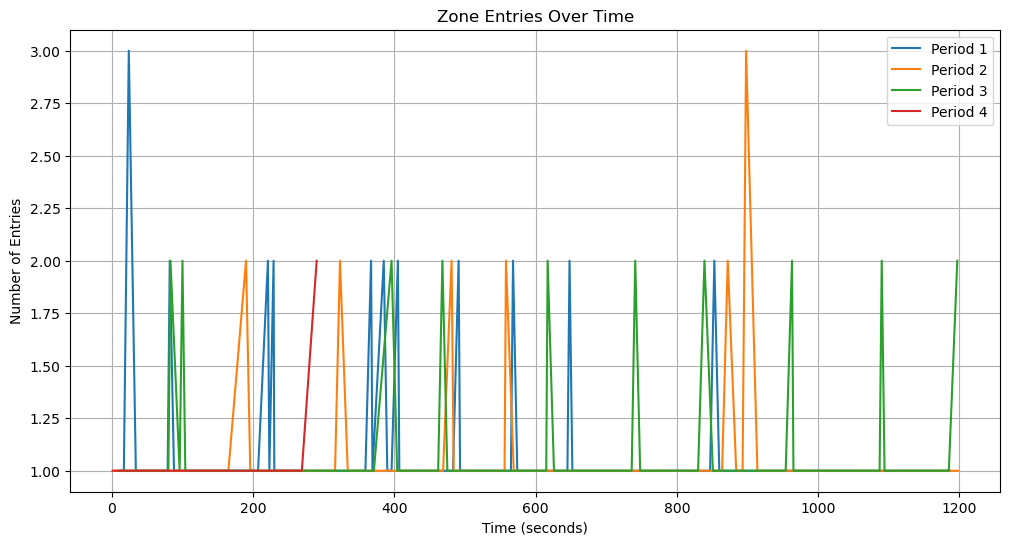

In [85]:
# Visualize Trends: Create a line plot
plt.figure(figsize=(12, 6))
for period in temporal_counts['Period'].unique():
    period_data = temporal_counts[temporal_counts['Period'] == period]
    plt.plot(period_data['Minute'] * 60 + period_data['Second'], period_data['Entry Count'], label=f'Period {period}')

plt.title('Zone Entries Over Time')
plt.xlabel('Time (seconds)')
plt.ylabel('Number of Entries')
plt.legend()
plt.grid(True)
plt.show()

Based on this graph, we notice some interesting things
1) At Period 4, there are only 2 zone entries after the 200-second mark.
2) Period 3 has the most consistent zone entries, there are 2 zone entries for 100 sec, 110 sec, 390 sec, 480 sec, 630 sec, 740 sec, 830 sec, 950 sec, 110 second, and 1180 sec.
3) During period 1, the highest number zone entries happened near the beginning of the period. 
4) During period 2, the highest number of zone entries happened near the 900 sec mark of the period.

# Don't Need this for Now

In [21]:
# Convert 'Clock' column to numerical values
df['Clock'] = pd.to_numeric(df['Clock'], errors='coerce')

# Define success criteria (e.g., shot on goal within 10 seconds of entry)

success_criteria = (df['Event'] == 'Shot') & (df['Detail 1'] == 'On Net') & (df['Clock'] <= 10)

# Filter the dataset to include only zone entries and subsequent successful events
successful_entries = df[(df['Event'] == 'Zone Entry') & success_criteria]

# Calculate total number of zone entries
total_entries = len(df[df['Event'] == 'Zone Entry'])

# Calculate success rate
success_rate = (len(successful_entries) / total_entries) * 100

print(f"Total Zone Entries: {total_entries}")
print(f"Successful Entries: {len(successful_entries)}")
print(f"Success Rate: {success_rate:.2f}%")

Total Zone Entries: 540
Successful Entries: 0
Success Rate: 0.00%


In [22]:
#Since the criteria for 10 seconds of entry lead to a 0% success rate, we will broaden the success criteria to 60 seconds of entry.
# Convert 'Clock' column to numerical values
df['Clock'] = pd.to_numeric(df['Clock'], errors='coerce')

# Define success criteria (e.g., shot on goal within 10 seconds of entry)

success_criteria = (df['Event'] == 'Shot') & (df['Detail 1'] == 'On Net') & (df['Clock'] <= 60)

# Filter the dataset to include only zone entries and subsequent successful events
successful_entries = df[(df['Event'] == 'Zone Entry') & success_criteria]

# Calculate total number of zone entries
total_entries = len(df[df['Event'] == 'Zone Entry'])

# Calculate success rate
success_rate = (len(successful_entries) / total_entries) * 100

print(f"Total Zone Entries: {total_entries}")
print(f"Successful Entries: {len(successful_entries)}")
print(f"Success Rate: {success_rate:.2f}%")

Total Zone Entries: 540
Successful Entries: 0
Success Rate: 0.00%


Even after changing the success criteria from 10 seconds to 60 seconds, the success rate is still at 0%. This suggests that none of the xone entries are leading to goals. Instead of focusing on a success being a goal being shot in 60 seconds, we will change the criteria to include the positive events from a zone entry.   

In [33]:
# Define revised success criteria
revised_success_criteria = ((df['Event'] == 'Shot')  & (df['Clock'] <= 60)) | \
                           (df['Event'] == 'Goal') | \
                           (df['Event'] == 'Takeaway') | \
                           ((df['Event'] == 'Play') | \
                           (df['Event'] == 'Dump In/Out'))

# Filter the dataset to include only zone entries and subsequent successful events
successful_entries = df[((df['Event'] == 'Zone Entry') & revised_success_criteria)]

# Calculate total number of zone entries
total_entries = len(df[df['Event'] == 'Zone Entry'])

# Calculate success rate
success_rate = (len(successful_entries) / total_entries) * 100

print(f"Total Zone Entries: {total_entries}")
print(f"Successful Entries: {len(successful_entries)}")
print(f"Success Rate: {success_rate:.2f}%")

Total Zone Entries: 540
Successful Entries: 0
Success Rate: 0.00%


Even after revising the success criteria to involve positive outcomes from a zone entry, we still get a 0% success rate, it's possible that there are no events in your dataset that meet the criteria for success after a zone entry. Because of this, we will move onto looking at the number of carried/dumped entries to see which strategy is more frequently utilized.

In [45]:
# Count the number of entries for each method
count_dumped = len(dumped_entries)
count_carried = len(carried_entries)

# Print the counts
print(f"Number of 'Dumped' entries: {count_dumped}")
print(f"Number of 'Carried' entries: {count_carried}")

# Compare the frequency of entry methods
if count_dumped > count_carried:
    print("There are more 'Dumped' entries.")
elif count_dumped < count_carried:
    print("There are more 'Carried' entries.")
else:
    print("The frequency of 'Dumped' and 'Carried' entries is the same.")


Number of 'Dumped' entries: 206
Number of 'Carried' entries: 267
There are more 'Carried' entries.


In [50]:
# Function to calculate possession retention
def calculate_possession_retention(entries):
    # Assuming possession retention is defined as maintaining control for at least 10 seconds
    retention_criteria = entries['Clock'] <= (entries['Clock'].min() + 10)
    possession_retention_rate = (retention_criteria.sum() / len(entries)) * 100
    return possession_retention_rate

# Calculate possession retention for dumped and carried entries
possession_retention_dumped = calculate_possession_retention(dumped_entries)
possession_retention_carried = calculate_possession_retention(carried_entries)

# Display the results
print("Possession Retention:")
print(f"Dumped Entries: {possession_retention_dumped:.2f}%")
print(f"Carried Entries: {possession_retention_carried:.2f}%")

Possession Retention:
Dumped Entries: 0.00%
Carried Entries: 0.00%
